<center> <h1>SAT Score Analysis</h1> </center>
<center> <h2>Simple Linear Regression Model Assumptions</h2> </center>
<center> <h3> Oliver Heady & Christopher Harris<h3> <center>

## Data and Description

Data Source: https://catalog.data.gov/dataset/2012-sat-results


We've all taken standardized tests, but while reflecting on their experiences, Chris and Oliver found that they had drastly different testing environmants, and wondered if that had an effect on their outcomes. Chris had a private proctor, and took his ACT alone, while Oliver studied using online tools, and took the test with hundreds of classmates in the high school gymnasium.

They found a dataset of SAT scores from 2012 that specified the number of students taking the test at a time, and knew this would be a great fit for their hypothesis!

The SAT Score data set compares the **number of students** taking the test at a specific time against the **average math score** of the students from that test-taking session.

#### 0. Load necessary libraries below.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns

#### 1. Read in the data set, and call the dataframe "sat". Print a summary of the data and make sure the data makes sense.


In [ ]:
sat = pd.read_table("/content/2012_SAT_Results.csv", delimiter=',')
sat.describe()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
count,478,478,478,478,478,478
unique,478,478,175,164,173,163
top,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,s,s,s,s
freq,1,1,57,57,57,57


In [ ]:
# Check for non-numeric values in the dataset
non_numeric_rows = {}

# We'll start by looking at columns from the third one onwards as the first two are strings by default
for column in sat.columns[2:]:
    non_numeric_indices = sat[pd.to_numeric(sat[column], errors='coerce').isna()].index
    if not non_numeric_indices.empty:
        non_numeric_rows[column] = non_numeric_indices

# Display rows with non-numeric values
non_numeric_data = {}
for column, indices in non_numeric_rows.items():
    non_numeric_data[column] = sat.loc[indices]

# Drop rows with non-numeric values in the SAT score columns
sat_c = sat.drop(non_numeric_rows['SAT Critical Reading Avg. Score'], axis=0)

# Display the shape of the original and cleaned datasets
original_shape = sat.shape
cleaned_shape = sat_c.shape

original_shape, cleaned_shape

sat_c.rename(columns={'Num of SAT Test Takers': 'scount', 'SAT Math Avg. Score': 'mathscore'}, inplace=True)


#### 2. Create a scatterplot of the data with variables on the appropriate axes


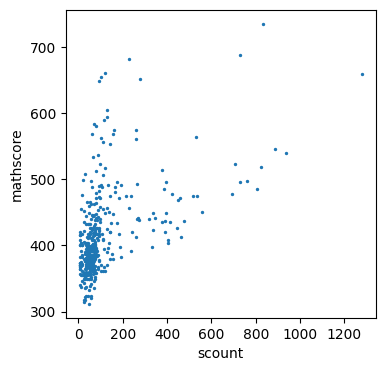

In [ ]:
# Convert the columns to numeric
sat_c['scount'] = pd.to_numeric(sat_c['scount'])
sat_c['mathscore'] = pd.to_numeric(sat_c['mathscore'])

x, y = sat_c['scount'], sat_c['mathscore']
b1, b0 = np.polyfit(x, y, 1)

fig = plt.figure(figsize=(4, 4))
plt.scatter(x = sat_c['scount'], y = sat_c['mathscore'], s = 2)
plt.xlabel("scount")
plt.ylabel("mathscore")
plt.show()

#### 3. Briefly describe the relationship between scount and mathscore.


Scount and mathscore have a medium strength positive linear correlation.

#### 4. OLS regression line added to the scatterplot.

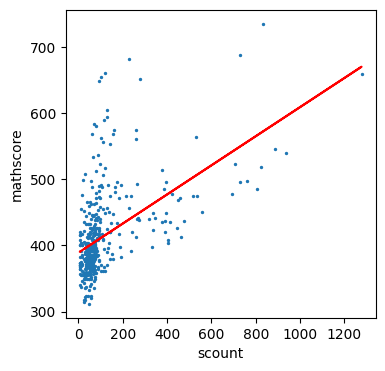

In [ ]:
x, y = sat_c['scount'], sat_c['mathscore']
b1, b0 = np.polyfit(x, y, 1)

fig = plt.figure(figsize=(4, 4))
plt.scatter(x = sat_c['scount'], y = sat_c['mathscore'], s = 2)
plt.plot(x, b1 * x + b0, 'r')
plt.xlabel("scount")
plt.ylabel("mathscore")
plt.show()

#### 5. Apply linear regression to the data.

In [ ]:
# Prepare data
y = sat_c['mathscore']
X = sm.add_constant(sat_c['scount'])
# Fit simple linear regression model using ordinary least squares
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())
sat_c['residuals'] = res.resid
sat_c['fittedvalues'] = res.fittedvalues

                            OLS Regression Results                            
Dep. Variable:              mathscore   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     162.8
Date:                Tue, 03 Oct 2023   Prob (F-statistic):           9.95e-32
Time:                        04:50:31   Log-Likelihood:                -2283.1
No. Observations:                 421   AIC:                             4570.
Df Residuals:                     419   BIC:                             4578.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        389.0978      3.285    118.439      0.0

#### 6. Fitted simple linear regression model for this data set using the coefficients you found above.

$\widehat{mathscore_i} = 389.1 + .22 \times scount_i$

### Run diagnostics to determine if the linear regression assumptions are met.

#### 7. (L) X vs Y is linear.


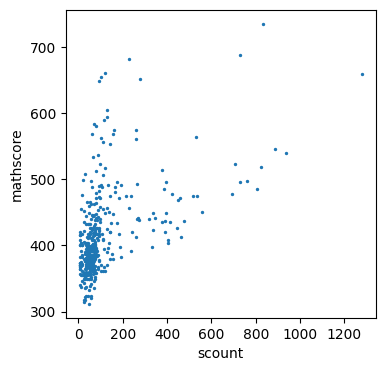

In [ ]:
# Scatterplot
fig = plt.figure(figsize = (4, 4))
plt.scatter(x = sat_c['scount'], y = sat_c['mathscore'], s = 2)
plt.xlabel("scount")
plt.ylabel("mathscore")
plt.show()

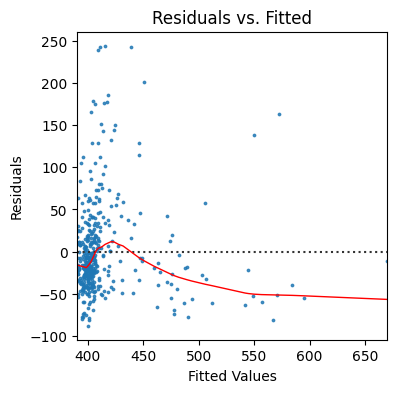

In [ ]:
# Residuals versus Fitted Values
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = sat_c['fittedvalues'], y = sat_c['residuals'],
                          lowess = True,
                          scatter_kws = {'s': 3},
                          line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

The X versus Y plot seems to have a bit of a curve - a transformation would probably fix this - we'll examine that later.

#### 8. (I) The residuals are independent.


Each datapoint is an independent school that should not have an impact on the other schools in New York sampled. So the residuals should be independent.

#### 9. (N) The residuals are normally distributed and centered at zero.

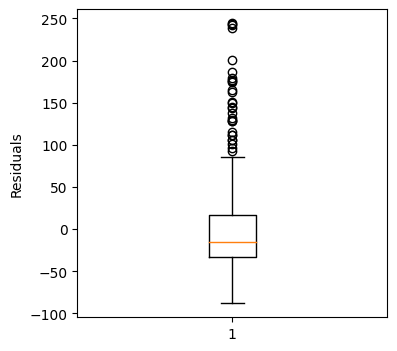

In [ ]:
# Box Plot
fig = plt.figure(figsize = (4, 4))
plt.boxplot(sat_c['residuals'])
plt.ylabel("Residuals")
plt.show()

The mean of the residuals is zero, which is a good sign. However the distribution seems to be right-skewed, which is a possible cause for concern.

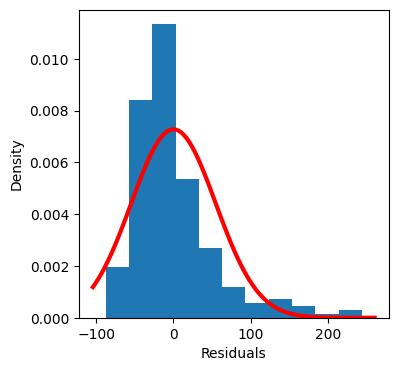

In [ ]:
# Histogram
fig = plt.figure(figsize = (4, 4))

# plot histogram (density=True so that it's on the same scale as the normal distribution)
plt.hist(sat_c['residuals'], density = True, bins = 11)
plt.xlabel("Residuals")
plt.ylabel("Density")

# calculate mean and standard deviation
mean = np.mean(sat_c['residuals'])
sd = np.std(sat_c['residuals'])

# generate x values to plot
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# plot normal distribution curve
plt.plot(x, stats.norm.pdf(x, mean, sd), color = 'r', lw = 3)
plt.show()

Again, the distribution looks highly skewed right, although the residuals are roughly centered around 0.

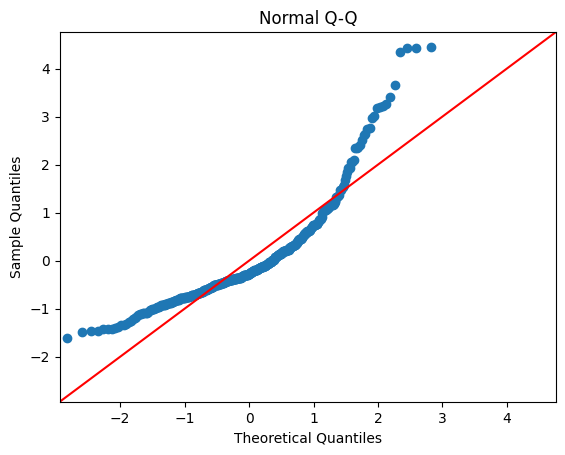

In [ ]:
# Normal Probability Plot
sm.qqplot(sat_c['residuals'], line = '45', fit = True)
plt.title("Normal Q-Q")
plt.show()

This plot should show that points follow the red line, however instead it follows a rather consistent curve so it should not be normally distributed.

#### 10. (E) The residuals have equal/constant variance across all values of X.

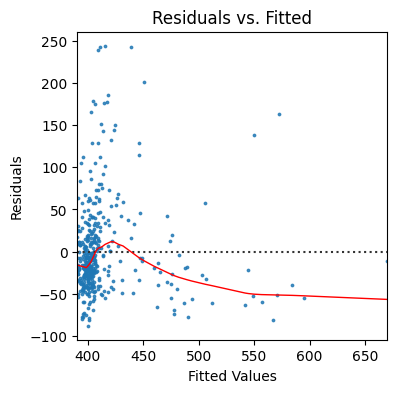

In [ ]:
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = sat_c['fittedvalues'], y = sat_c['residuals'],
                          lowess = True,
                          scatter_kws = {'s': 3},
                          line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

The residuals should be equally spread around the horizontal line. There may be slightly more spread at larger fitted values than at smaller fitted values, thought it is not dramatic. This is only mildly concerning.

#### 11. (A) The model describes all observations with no influential points.

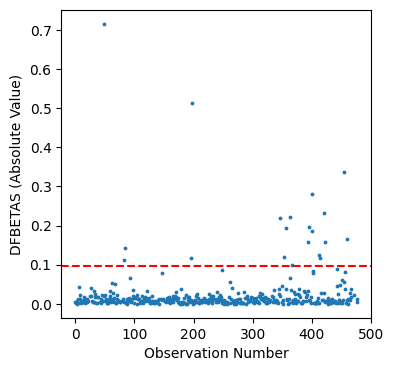

,DBN,SCHOOL NAME,scount,SAT Critical Reading Avg. Score,mathscore,SAT Writing Avg. Score,residuals,fittedvalues,dfbetas
48,02M475,STUYVESANT HIGH SCHOOL,832,679,735,682,162.863813,572.136187,0.716088
198,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632,688,649,138.083612,549.916388,0.513215
396,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621,651,638,200.742709,450.257291,0.196072
459,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635,682,636,242.962608,439.037392,0.166171
84,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566,564,577,58.083213,505.916787,0.142321
83,03M479,BEACON HIGH SCHOOL,261,577,575,592,128.482675,446.517325,0.111625
366,22K535,LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES,259,524,561,542,114.922671,446.077329,0.098383
414,27Q480,JOHN ADAMS HIGH SCHOOL,403,391,409,392,-68.757042,477.757042,-0.116210
196,10X440,DEWITT CLINTON HIGH SCHOOL,443,419,426,410,-60.556962,486.556962,-0.116579
353,21K410,ABRAHAM LINCOLN HIGH SCHOOL,475,396,437,393,-56.596898,493.596898,-0.119681


In [ ]:
# DFBETAS
dir(res)
res.get_influence().dfbetas
sat_c['dfbetas'] = res.get_influence().dfbetas[:,1]

fig = plt.figure(figsize = (4, 4))
plt.ylabel("DFBETAS (Absolute Value)")
plt.xlabel("Observation Number")
plt.scatter(sat_c.index, np.abs(sat_c['dfbetas']), s = 3)
plt.axhline(y = 2 / np.sqrt(len(sat_c)), color = 'r', linestyle = 'dashed')
plt.show()

# OPTIONAL: code to grab potential outliers
outliers_dfbetas = sat_c[np.abs(sat_c['dfbetas']) > 2 / np.sqrt(len(sat_c))]
outliers_dfbetas.sort_values(by = 'dfbetas', ascending = False)

This DFBETAS chart shows that there are some potential influential points, however, there doesn't seem to be to great of a difference between it and the other ones on the y axis so it should be okay to leave it in.

In [ ]:
# DFFITS
res.get_influence().dffits
len(res.params)

2

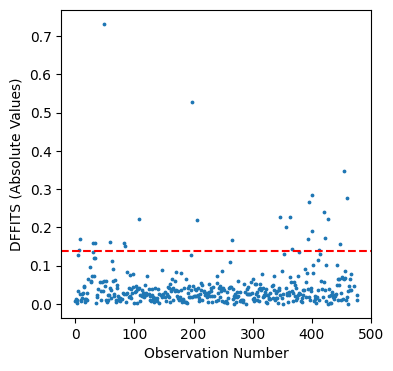

In [ ]:
# DFFITS
sat_c['dffits'] = res.get_influence().dffits[0]

fig = plt.figure(figsize = (4, 4))
plt.ylabel("DFFITS (Absolute Values)")
plt.xlabel("Observation Number")
plt.scatter(sat_c.index, np.abs(sat_c['dffits']), s = 3)
plt.axhline(y = 2 * np.sqrt(len(res.params) / len(sat_c)), color = 'r', linestyle = 'dashed')
plt.show()

# OPTIONAL: code to grab potential outliers
# outliers_dffits = cars[np.abs(cars['dffits']) > 2*np.sqrt(len(res.params)/len(cars))]
# outliers_dffits.sort_values(by = 'dffits', ascending = False)

Again, there are some points that have potential to be influential points, however the gap in the score on the y axis isn't too extreme that we would need to replace them.

#### 12. (R) Additional predictor variables are not required.

This assumption probably is not met - lots of other variables could influence the score, such as what grade level the student is in.

#### 13. Does this linear regression model fit the raw data?

The data seems to break many of the assumptions for linear regression. It is not the most linear of datasets, as seen in the scatterplot. It doesn't have roughly normal distributions but rather they are skewed right. And there are other predictor variables that may be unaccounted for.

#### 14. Fix the model by making any necessary transformations.

(array([1.66776166e-03, 9.75949417e-03, 7.28873615e-03, 3.15021647e-03,
        2.03837536e-03, 6.79458455e-04, 6.79458455e-04, 2.47075802e-04,
        1.85306851e-04, 2.47075802e-04, 6.17689504e-05]),
 array([312.        , 350.45454545, 388.90909091, 427.36363636,
        465.81818182, 504.27272727, 542.72727273, 581.18181818,
        619.63636364, 658.09090909, 696.54545455, 735.        ]),
 <BarContainer object of 11 artists>)

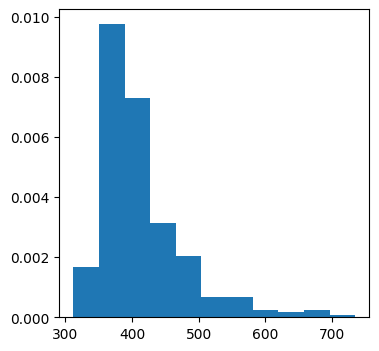

In [ ]:
# Plot original Y
fig = plt.figure(figsize = (4, 4))
plt.hist(sat_c['mathscore'], density = True, bins = 11)

(array([0.39640613, 1.79907399, 4.20800358, 2.77484294, 1.46365342,
        1.09774006, 0.36591335, 0.36591335, 0.12197112, 0.1524639 ,
        0.09147834]),
 array([5.74300319, 5.82090022, 5.89879724, 5.97669427, 6.0545913 ,
        6.13248833, 6.21038536, 6.28828239, 6.36617941, 6.44407644,
        6.52197347, 6.5998705 ]),
 <BarContainer object of 11 artists>)

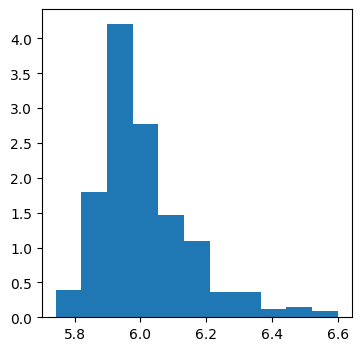

In [ ]:
# Plot log(Y) transform
sat_transformed = np.log(sat_c['mathscore'])
fig = plt.figure(figsize = (4, 4))
plt.hist(sat_transformed, density = True, bins = 11)

After attempting both a square root transformation and a log transformation, we've decided to go with the log(y) transformation since it looks slightly more normal than the original Y.

In [ ]:
# Transform y using log
y_transformed = np.log(sat_c['mathscore'])

X = sm.add_constant(sat_c['scount'])

# Fit simple linear regression model using ordinary least squares on the transformed y
mod = sm.OLS(y_transformed, X)
res = mod.fit()

#print(res.summary())

sat_c['residuals'] = res.resid
sat_c['fittedvalues'] = res.fittedvalues

### Re-check your transformed model to verify the assumption.

#### 15. (L) Linearity

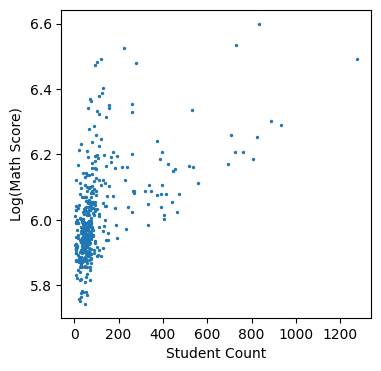

In [ ]:
# Scatterplot with log-transformed y-values
fig = plt.figure(figsize = (4, 4))
plt.scatter(x=sat_c['scount'], y=np.log(sat_c['mathscore']), s=2)
plt.xlabel("Student Count")
plt.ylabel("Log(Math Score)")
plt.show()

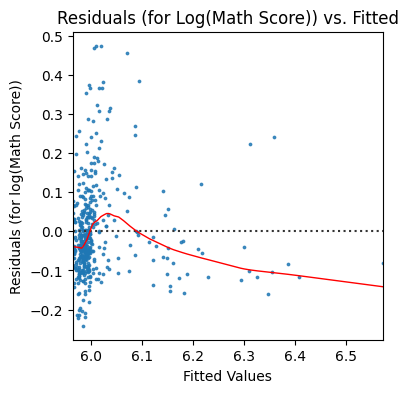

In [ ]:
# Residuals vs Fitted Values
fig = plt.figure(figsize=(4, 4))
sns.residplot(x=sat_c['fittedvalues'], y=sat_c['residuals'],
              lowess=True,
              scatter_kws={'s': 3},
              line_kws={'color': 'red', 'lw': 1})
plt.title("Residuals (for Log(Math Score)) vs. Fitted")
plt.ylabel("Residuals (for log(Math Score))")
plt.xlabel("Fitted Values")
plt.show()


These may be a bit better, but not by much. The linear assumption is still not met.

#### 16. (N) The residuals are normally distributed and centered at zero.

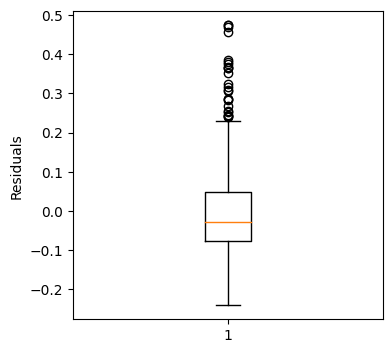

In [ ]:
# Box Plot
fig = plt.figure(figsize = (4, 4))
plt.boxplot(sat_c['residuals'])
plt.ylabel("Residuals")
plt.show()

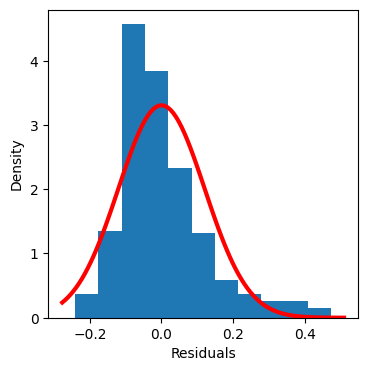

In [ ]:
# Histogram
fig = plt.figure(figsize = (4, 4))

# plot histogram (density=True so that it's on the same scale as the normal distribution)
plt.hist(sat_c['residuals'], density = True, bins = 11)
plt.xlabel("Residuals")
plt.ylabel("Density")

# calculate mean and standard deviation
mean = np.mean(sat_c['residuals'])
sd = np.std(sat_c['residuals'])

# generate x values to plot
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# plot normal distribution curve
plt.plot(x, stats.norm.pdf(x, mean, sd), color = 'r', lw = 3)
plt.show()

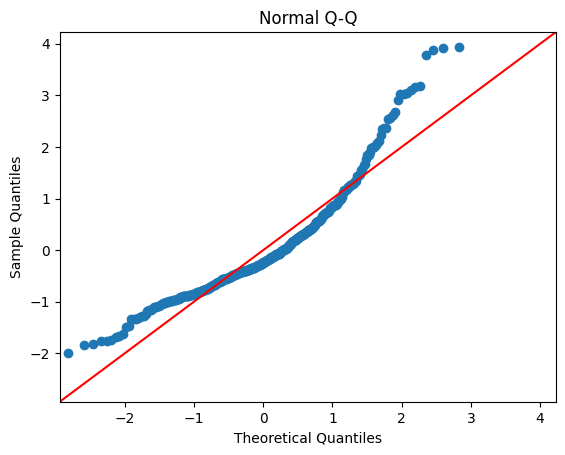

In [ ]:
# Normal Probability Plot
sm.qqplot(sat_c['residuals'], line = '45', fit = True)
plt.title("Normal Q-Q")
plt.show()

These do look more normal than our original residuals, but they're still pretty right-skewed. Assumption still not met.



#### 17. (E) The residuals have equal/constant variance across all values of X.

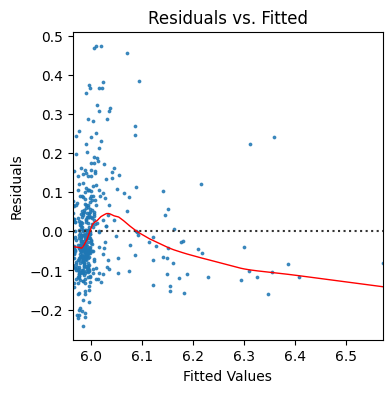

In [ ]:
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = sat_c['fittedvalues'], y = sat_c['residuals'],
                          lowess = True,
                          scatter_kws = {'s': 3},
                          line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

The residuals do not seem to vary constantly over all values of X. Assumption not met.


#### 18. (A) The model describes all observations.

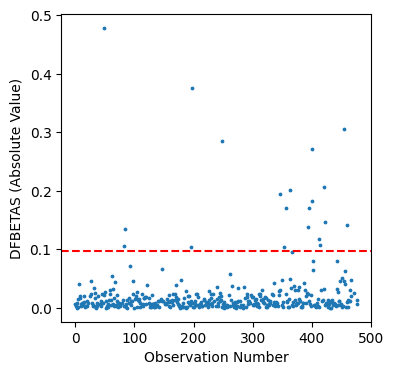

,DBN,SCHOOL NAME,scount,SAT Critical Reading Avg. Score,mathscore,SAT Writing Avg. Score,residuals,fittedvalues,dfbetas,dffits
48,02M475,STUYVESANT HIGH SCHOOL,832,679,735,682,0.240935,6.358935,0.478556,0.732491
198,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632,688,649,0.223174,6.310615,0.375648,0.529045
396,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621,651,638,0.384619,6.093890,0.170078,0.267287
459,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635,682,636,0.455539,6.069491,0.140672,0.276697
84,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566,564,577,0.120124,6.214931,0.133766,0.151715
83,03M479,BEACON HIGH SCHOOL,261,577,575,592,0.268613,6.085757,0.106007,0.160327
196,10X440,DEWITT CLINTON HIGH SCHOOL,443,419,426,410,-0.118390,6.172830,-0.103564,-0.128664
353,21K410,ABRAHAM LINCOLN HIGH SCHOOL,475,396,437,393,-0.108206,6.188139,-0.103971,-0.130087
414,27Q480,JOHN ADAMS HIGH SCHOOL,403,391,409,392,-0.139978,6.153693,-0.107506,-0.131565
413,27Q475,RICHMOND HILL HIGH SCHOOL,404,382,404,368,-0.152756,6.154171,-0.117765,-0.141982


In [ ]:
# DFBETAS
dir(res)
res.get_influence().dfbetas
sat_c['dfbetas'] = res.get_influence().dfbetas[:,1]

fig = plt.figure(figsize = (4, 4))
plt.ylabel("DFBETAS (Absolute Value)")
plt.xlabel("Observation Number")
plt.scatter(sat_c.index, np.abs(sat_c['dfbetas']), s = 3)
plt.axhline(y = 2 / np.sqrt(len(sat_c)), color = 'r', linestyle = 'dashed')
plt.show()

# OPTIONAL: code to grab potential outliers
outliers_dfbetas = sat_c[np.abs(sat_c['dfbetas']) > 2 / np.sqrt(len(sat_c))]
outliers_dfbetas.sort_values(by = 'dfbetas', ascending = False)

In [ ]:
# DFFITS
res.get_influence().dffits
len(res.params)

2

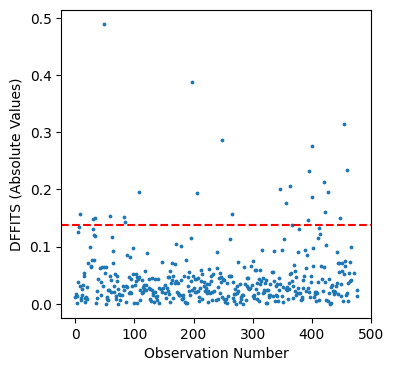

In [ ]:
# DFFITS
sat_c['dffits'] = res.get_influence().dffits[0]

fig = plt.figure(figsize = (4, 4))
plt.ylabel("DFFITS (Absolute Values)")
plt.xlabel("Observation Number")
plt.scatter(sat_c.index, np.abs(sat_c['dffits']), s = 3)
plt.axhline(y = 2 * np.sqrt(len(res.params) / len(sat_c)), color = 'r', linestyle = 'dashed')
plt.show()

# OPTIONAL: code to grab potential outliers
# outliers_dffits = cars[np.abs(cars['dffits']) > 2*np.sqrt(len(res.params)/len(cars))]
# outliers_dffits.sort_values(by = 'dffits', ascending = False)

Both the DFBETAS and DFFITS plots have many 'influential points' above the threshold, and we can't pinpoint any specific ones that might be causing the problem.

#### 19. Fitted simple linear regression model for this data set.

$\log(mathscore_i) = 5.961 + .001 \times (scount_i)$

#### 20. New fitted curve on the scatterplot of the original data.

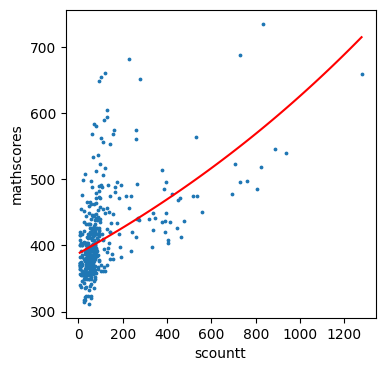

In [ ]:
x, y = sat_c['scount'], sat_c['mathscore']

# Create a sequence of Weight values
scount_values = np.linspace(sat_c['scount'].min(), sat_c['scount'].max(), num = 100)

# Predict log(mathscore) using the linear model
X = sm.add_constant(pd.DataFrame({'scount': scount_values}))
log_mathscores_preds = res.predict(X)

# Back-transform the predictions to mathscore
mathscores_preds = np.exp(log_mathscores_preds)

# Store results in a DataFrame for plotting
preds = pd.DataFrame({"scount_values": scount_values, "mathscores_preds": mathscores_preds})

# Plot the predictions on the original scale
plt.figure(figsize = (4, 4))
plt.scatter(x, y, s = 3)
plt.plot(preds['scount_values'], preds['mathscores_preds'], color = "r")
plt.xlabel("scountt")
plt.ylabel("mathscores")
plt.show()

This curve appears to fit the data slightly better.

####Model Assessment

In [ ]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              mathscore   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     159.1
Date:                Tue, 03 Oct 2023   Prob (F-statistic):           3.87e-31
Time:                        04:50:39   Log-Likelihood:                 293.07
No. Observations:                 421   AIC:                            -582.1
Df Residuals:                     419   BIC:                            -574.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9609      0.007    824.736      0.0

The new model has an adjusted r squared of .273. This means that roughly 27.3 percent of the change in mathscores is accounted for in the change of student count.

The p value for the slope is also less than .05, so we reject the null, and the results are statistically significant.

####21. Confidence Inverval

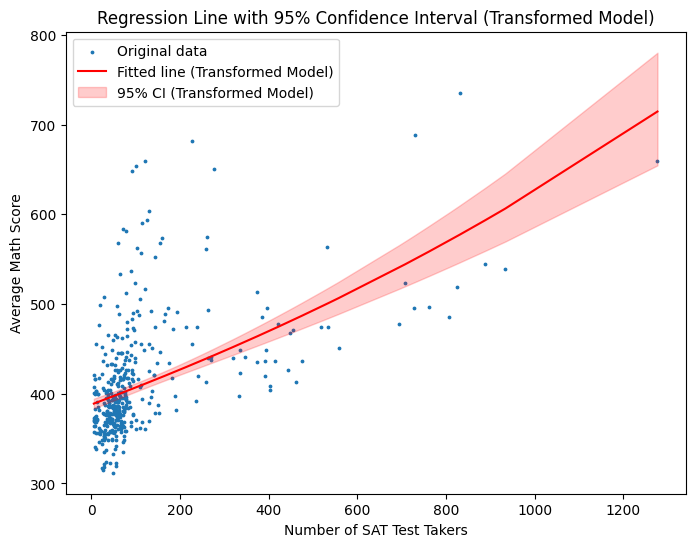

In [ ]:
# Transforming the dependent variable
sat_c['log_mathscore'] = np.log(sat_c['mathscore'])

# Fitting a linear model to the transformed dependent variable
model_log = sm.OLS(sat_c['log_mathscore'], sm.add_constant(sat_c['scount'])).fit()

# Getting predictions
preds_log = model_log.get_prediction().summary_frame(alpha=0.05)  # 95% CI
preds_log['scount_values'] = sat_c['scount'].values
preds_log = preds_log.sort_values(by='scount_values')

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(sat_c['scount'], sat_c['mathscore'], s=3, label='Original data')
plt.plot(preds_log['scount_values'], np.exp(preds_log['mean']), color='r', label='Fitted line (Transformed Model)')
plt.fill_between(preds_log['scount_values'], np.exp(preds_log['mean_ci_lower']), np.exp(preds_log['mean_ci_upper']),
                 color='red', alpha=0.2, label='95% CI (Transformed Model)')
plt.xlabel("Number of SAT Test Takers")
plt.ylabel("Average Math Score")
plt.title("Regression Line with 95% Confidence Interval (Transformed Model)")
plt.legend()
plt.show()

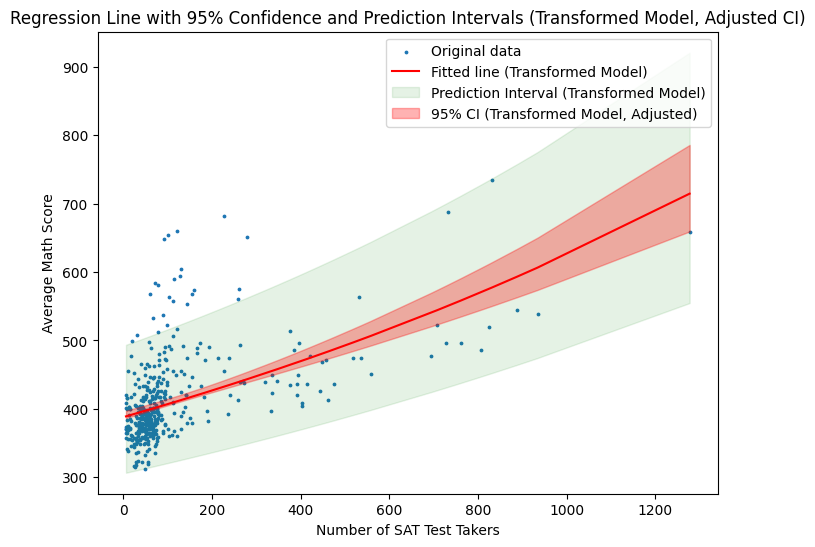

In [ ]:
# Calculating the smearing factor
residuals = model_log.resid
smearing_factor = np.exp(residuals.mean() + 0.5 * (residuals**2).mean())

# Adjusting the confidence interval using the smearing factor
preds_log['adj_mean_ci_lower'] = np.exp(preds_log['mean_ci_lower']) * smearing_factor
preds_log['adj_mean_ci_upper'] = np.exp(preds_log['mean_ci_upper']) * smearing_factor

# Plotting with the adjusted confidence interval
plt.figure(figsize=(8, 6))
plt.scatter(sat_c['scount'], sat_c['mathscore'], s=3, label='Original data')
plt.plot(pred_interval['scount_values'], pred_interval['exp_mean'], color='r', label='Fitted line (Transformed Model)')

# Adjusting alpha and order of shaded areas for visibility
plt.fill_between(pred_interval['scount_values'], pred_interval['exp_obs_ci_lower'], pred_interval['exp_obs_ci_upper'],
                 color='green', alpha=0.1, label='Prediction Interval (Transformed Model)')
plt.fill_between(pred_interval['scount_values'], preds_log['adj_mean_ci_lower'], preds_log['adj_mean_ci_upper'],
                 color='red', alpha=0.3, label='95% CI (Transformed Model, Adjusted)')

plt.xlabel("Number of SAT Test Takers")
plt.ylabel("Average Math Score")
plt.title("Regression Line with 95% Confidence and Prediction Intervals (Transformed Model, Adjusted CI)")
plt.legend()
plt.show()

#### 22. Briefly summarize what you learned from this analysis.



**Purpose of the Data Set and Analysis:** We looked at data comparing the size of the group taking the sat and the average math scores for the group in order to see if there was any sort of relationship between the two variables.


**Findings:** After running through the regression analysis we discovered that there is not a correlation between the size of the group you take a test with and the average math result on the sat. This was interesting as it went against our original hypothesis that taking the test with a smaller group would have an impact on the overall scores.
